In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR

### Loading the overall data

In [2]:
df = pd.read_excel('C:\\Users\\nithi\\OneDrive\\Desktop\\Fatigue_Data\\Processing Parameters\\Total_Data.xlsx')

In [3]:
df.head()

,Power,Layer thickness,Scan Velocity,Hatch Spacing,Stress Amplitude (Mpa),No of Cycles (N),Log Scale
0,120,30,1200,0.07,290.0,127000,5.103804
1,120,30,1200,0.07,232.0,231000,5.363612
2,120,30,1200,0.07,204.0,224000,5.350248
3,120,30,1200,0.07,232.0,366000,5.563481
4,120,30,1200,0.07,263.0,779000,5.891537


#### Checking the value counts of each of the columns

In [4]:
df['Power'].value_counts()

160    54
120    37
200    34
Name: Power, dtype: int64

In [5]:
df['Layer thickness'].value_counts()

30    57
45    41
60    27
Name: Layer thickness, dtype: int64

In [6]:
df['Scan Velocity'].value_counts()

1000    59
800     34
1200    32
Name: Scan Velocity, dtype: int64

In [7]:
df['Hatch Spacing'].value_counts()

0.07    54
0.10    36
0.13    35
Name: Hatch Spacing, dtype: int64

In [8]:
df.corr()

,Power,Layer thickness,Scan Velocity,Hatch Spacing,Stress Amplitude (Mpa),No of Cycles (N),Log Scale
Power,1.000000,0.003794,-0.044559,0.058143,0.232488,0.012096,-0.044622
Layer thickness,0.003794,1.000000,-0.020793,0.140674,-0.595776,-0.196688,-0.252598
Scan Velocity,-0.044559,-0.020793,1.000000,0.049038,-0.115484,-0.011247,-0.083557
Hatch Spacing,0.058143,0.140674,0.049038,1.000000,-0.393804,-0.021805,0.027278
Stress Amplitude (Mpa),0.232488,-0.595776,-0.115484,-0.393804,1.000000,-0.153485,-0.299385
No of Cycles (N),0.012096,-0.196688,-0.011247,-0.021805,-0.153485,1.000000,0.737256
Log Scale,-0.044622,-0.252598,-0.083557,0.027278,-0.299385,0.737256,1.000000


#### Creating a derived column from the independant processing parameters as the value counts of each of the columns are less

In [9]:
df['Energy'] = 1000*df['Power']/(df['Layer thickness']*df['Scan Velocity']*df['Hatch Spacing'])

#### Considering the only columns which are useful for the predictions of fatigue life. Normalized the Fatigue life variable to log Scale

In [10]:
Total_Data = df.loc[:,['Energy','Stress Amplitude (Mpa)','Log Scale']]
Total_Data

,Energy,Stress Amplitude (Mpa),Log Scale
0,47.619048,290.0,5.103804
1,47.619048,232.0,5.363612
2,47.619048,204.0,5.350248
3,47.619048,232.0,5.563481
4,47.619048,263.0,5.891537
...,...,...,...
120,28.490028,130.0,7.418301
121,28.490028,130.0,7.746634
122,28.490028,135.0,7.904174
123,28.490028,130.0,8.532754


In [11]:
Total_Data['Energy'].value_counts()

76.190476    19
26.666667    16
41.025641    14
63.492063    13
28.490028    12
47.619048    12
83.333333    12
47.619048    10
19.230769     9
22.222222     8
Name: Energy, dtype: int64

### Z Score Normalization

In [12]:
Total_Data['Energy'] = (Total_Data['Energy'] - Total_Data['Energy'].mean())/(Total_Data['Energy'].std())

In [13]:
Total_Data['Energy']

0     -0.022842
1     -0.022842
2     -0.022842
3     -0.022842
4     -0.022842
         ...   
120   -0.903554
121   -0.903554
122   -0.903554
123   -0.903554
124   -0.903554
Name: Energy, Length: 125, dtype: float64

In [14]:
Total_Data['Stress Amplitude (Mpa)'] = (Total_Data['Stress Amplitude (Mpa)'] - Total_Data['Stress Amplitude (Mpa)'].mean())/(Total_Data['Stress Amplitude (Mpa)'].std())

In [15]:
Total_Data['Stress Amplitude (Mpa)']

0      1.459673
1      0.601821
2      0.187686
3      0.601821
4      1.060328
         ...   
120   -0.906814
121   -0.906814
122   -0.832861
123   -0.906814
124   -0.906814
Name: Stress Amplitude (Mpa), Length: 125, dtype: float64

In [16]:
Total_Data.isnull().sum()

Energy                    0
Stress Amplitude (Mpa)    0
Log Scale                 0
dtype: int64

<AxesSubplot:xlabel='Stress Amplitude (Mpa)', ylabel='Density'>

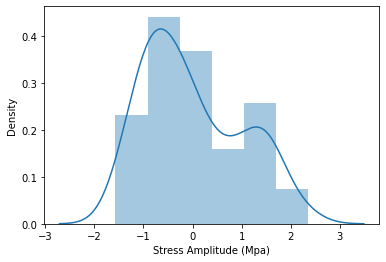

In [17]:
sns.distplot(Total_Data['Stress Amplitude (Mpa)'])

<AxesSubplot:xlabel='Energy', ylabel='Density'>

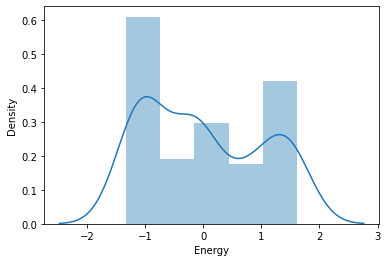

In [18]:
sns.distplot(Total_Data['Energy'])

#### Checking for corretaion between the columns 

In [19]:
Total_Data.corr()

,Energy,Stress Amplitude (Mpa),Log Scale
Energy,1.000000,0.742589,0.126992
Stress Amplitude (Mpa),0.742589,1.000000,-0.299385
Log Scale,0.126992,-0.299385,1.000000


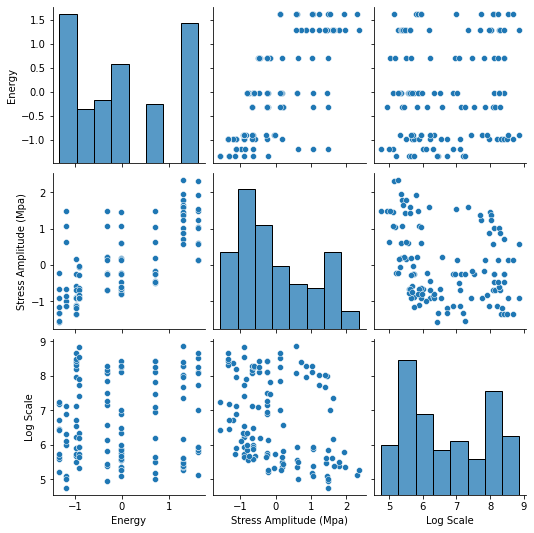

In [20]:
sns.pairplot(Total_Data)

<AxesSubplot:>

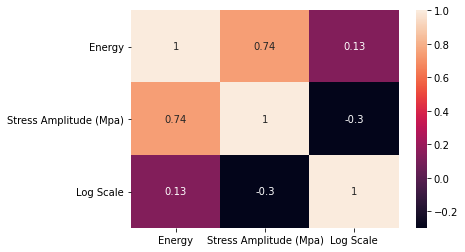

In [21]:
sns.heatmap(Total_Data.corr(),annot = True)

<AxesSubplot:>

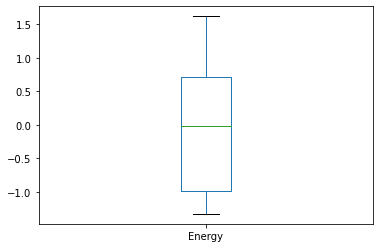

In [22]:
Total_Data['Energy'].plot.box()

<AxesSubplot:>

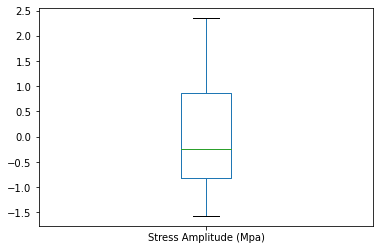

In [23]:
Total_Data['Stress Amplitude (Mpa)'].plot.box()

In [24]:
Total_Data.describe()

,Energy,Stress Amplitude (Mpa),Log Scale
count,1.250000e+02,1.250000e+02,125.000000
mean,-1.952216e-15,2.060574e-16,6.712924
std,1.000000e+00,1.000000e+00,1.199457
min,-1.329857e+00,-1.569431e+00,4.759668
25%,-9.875030e-01,-8.180709e-01,5.647383
50%,-2.284156e-02,-2.412397e-01,6.428135
75%,7.079626e-01,8.680511e-01,7.988113
max,1.621468e+00,2.347105e+00,8.872739


In [25]:
print('Max value for outlier Energy',  0.70+1.5*(0.70+0.98))

Max value for outlier Energy 3.2199999999999998


In [26]:
print('Max value for outlier Stress Amplitude',  0.86+1.5*(0.86+0.81))

Max value for outlier Stress Amplitude 3.3649999999999998


In [27]:
print('Min value for outlier Stress Amplitude',  -0.81-1.5*(0.86+0.81))

Min value for outlier Stress Amplitude -3.315


In [28]:
print('Min value for outlier Energy',  -0.98-1.5*(0.70+0.98))

Min value for outlier Energy -3.5


In [29]:
Scat = Total_Data.groupby('Energy')['Stress Amplitude (Mpa)'].mean().reset_index()
Scat

,Energy,Stress Amplitude (Mpa)
0,-1.329857,-1.115854
1,-1.192128,-0.200566
2,-0.987503,-0.952110
3,-0.903554,-0.665235
4,-0.326406,0.002804
5,-0.022842,0.133454
6,-0.022842,-0.600650
7,0.707963,0.029541
8,1.292606,1.406738
9,1.621468,1.009794


Text(0.5, 1.0, 'Reg Plot Energy Density vs Stress Amplitude (MPa)')

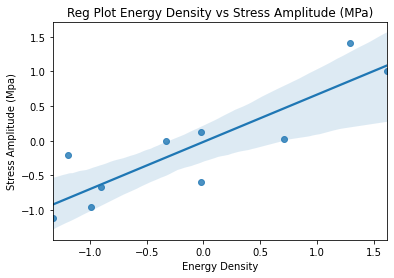

In [30]:
sns.regplot(Scat['Energy'],Scat['Stress Amplitude (Mpa)'])
plt.xlabel('Energy Density')
plt.ylabel('Stress Amplitude (Mpa)')
plt.title('Reg Plot Energy Density vs Stress Amplitude (MPa)')

In [31]:
Total_Data

,Energy,Stress Amplitude (Mpa),Log Scale
0,-0.022842,1.459673,5.103804
1,-0.022842,0.601821,5.363612
2,-0.022842,0.187686,5.350248
3,-0.022842,0.601821,5.563481
4,-0.022842,1.060328,5.891537
...,...,...,...
120,-0.903554,-0.906814,7.418301
121,-0.903554,-0.906814,7.746634
122,-0.903554,-0.832861,7.904174
123,-0.903554,-0.906814,8.532754


In [32]:
X = Total_Data[['Energy','Stress Amplitude (Mpa)']]
Y = Total_Data[['Log Scale']]

In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state = 57)

<AxesSubplot:xlabel='Stress Amplitude (Mpa)', ylabel='Density'>

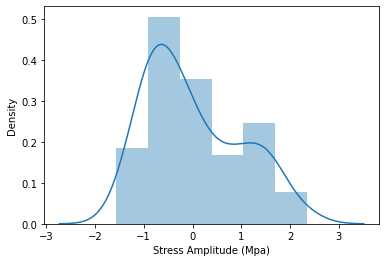

In [34]:
sns.distplot(X_train['Stress Amplitude (Mpa)'])

<AxesSubplot:xlabel='Stress Amplitude (Mpa)', ylabel='Density'>

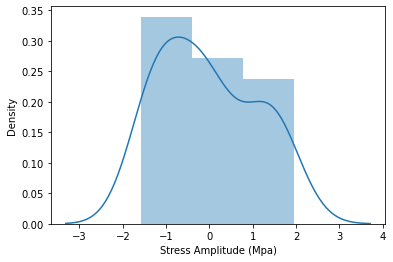

In [35]:
sns.distplot(X_test['Stress Amplitude (Mpa)'])

<AxesSubplot:xlabel='Energy', ylabel='Density'>

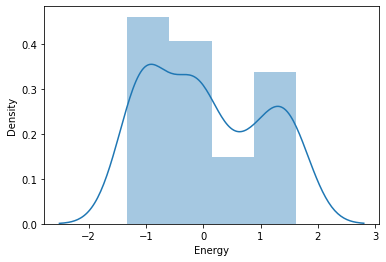

In [36]:
sns.distplot(X_train['Energy'])

<AxesSubplot:xlabel='Energy', ylabel='Density'>

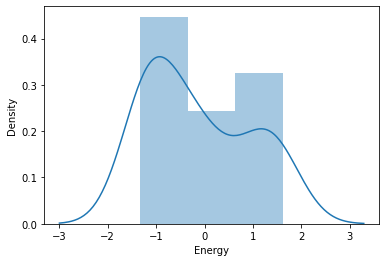

In [37]:
sns.distplot(X_test['Energy'])

In [38]:
list_r2 = []
list_mse = []
list_mae = []

In [39]:
estimator = RandomForestRegressor()
param_grid = { 
            "n_estimators"      : [30,50,100],
            "max_features"      : ["auto", "sqrt", "log2"],
            "min_samples_split" : [2,4,8],
            "bootstrap": [True, False],
            "criterion" : ['mse','mae']
            }

grid_rf = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=6)

grid_rf.fit(X_train, Y_train)
print('Best Parameters:\n',grid_rf.best_params_)

Best Parameters:
 {'bootstrap': True, 'criterion': 'mse', 'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 100}


In [40]:
grid_rf.get_params()

{'cv': 6,
 'error_score': nan,
 'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'mse',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(),
 'n_jobs': -1,
 'param_grid': {'n_estimators': [30, 50, 100],
  'max_features': ['auto', 'sqrt', 'log2'],
  'min_samples_split': [2, 4, 8],
  'bootstrap': [True, False],
  'criterion': ['mse', 'mae']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [41]:
Y_predict = grid_rf.predict(X_test)
r2_rf_test = r2_score(Y_test,Y_predict)
print('Random Forest Test set R2 Score is',r2_score(Y_test,Y_predict))
list_r2.append(r2_score(Y_test,Y_predict))
list_mse.append(mean_squared_error(Y_test,Y_predict))
list_mae.append(mean_absolute_error(Y_test,Y_predict))

Random Forest Test set R2 Score is 0.7638943648103034


In [42]:
r2_rf_train = r2_score(Y_train,grid_rf.predict(X_train))
print('Random Forest Train set R2 score is',r2_score(Y_train,grid_rf.predict(X_train)))

Random Forest Train set R2 score is 0.7869174273110855


Text(0.5, 1.0, 'RF Q-Q Plot')

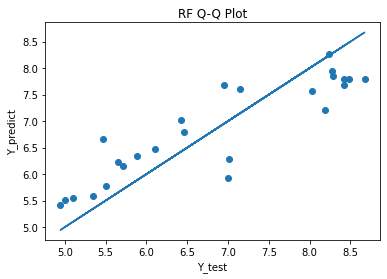

In [43]:
plt.scatter(Y_test,Y_predict)
plt.plot(Y_test,Y_test)
plt.xlabel('Y_test')
plt.ylabel('Y_predict')
plt.title('RF Q-Q Plot')

Text(0.5, 1.0, 'Random Forest R2 Scores Compared')

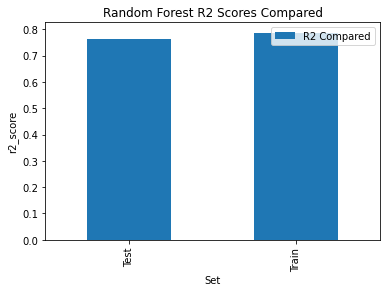

In [44]:
Scores = pd.DataFrame({'Set' : ['Test','Train'],
                        'R2 Compared' : [r2_rf_test,r2_rf_train]})
Scores.set_index('Set', inplace = True)
Scores.plot.bar()
plt.ylabel('r2_score')
plt.title('Random Forest R2 Scores Compared')

In [45]:
estimator = XGBRegressor()
param_grid = { 
            "booster"      : ['gbtree', 'gblinear'],
            "max_depth"      : [2,4,6,8],
            "lambda" : [0.5,1,1.5,2],
            "learning_rate": [0.1,0.2,0.3,0.4,0.5],
            }

grid_xg = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=6)

grid_xg.fit(X_train, Y_train)
print('Best Parameters:\n',grid_xg.best_params_)

Best Parameters:
 {'booster': 'gbtree', 'lambda': 0.5, 'learning_rate': 0.2, 'max_depth': 2}


In [46]:
grid_xg.get_params()

{'cv': 6,
 'error_score': nan,
 'estimator__objective': 'reg:squarederror',
 'estimator__base_score': None,
 'estimator__booster': None,
 'estimator__colsample_bylevel': None,
 'estimator__colsample_bynode': None,
 'estimator__colsample_bytree': None,
 'estimator__gamma': None,
 'estimator__gpu_id': None,
 'estimator__importance_type': 'gain',
 'estimator__interaction_constraints': None,
 'estimator__learning_rate': None,
 'estimator__max_delta_step': None,
 'estimator__max_depth': None,
 'estimator__min_child_weight': None,
 'estimator__missing': nan,
 'estimator__monotone_constraints': None,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__num_parallel_tree': None,
 'estimator__random_state': None,
 'estimator__reg_alpha': None,
 'estimator__reg_lambda': None,
 'estimator__scale_pos_weight': None,
 'estimator__subsample': None,
 'estimator__tree_method': None,
 'estimator__validate_parameters': None,
 'estimator__verbosity': None,
 'estimator': XGBRegressor(b

In [47]:
Y_predict = grid_xg.predict(X_test)
r2_xg_test = r2_score(Y_test,Y_predict)
print('XG Boost Test set R2 Score is',r2_score(Y_test,Y_predict))
list_r2.append(r2_score(Y_test,Y_predict))
list_mse.append(mean_squared_error(Y_test,Y_predict))
list_mae.append(mean_absolute_error(Y_test,Y_predict))

XG Boost Test set R2 Score is 0.8321718170827213


In [48]:
Y_predict_train = grid_xg.predict(X_train)
r2_xg_train = r2_score(Y_train,Y_predict_train)
print('XG Boost Train set R2 Score is',r2_score(Y_train,Y_predict_train))

XG Boost Train set R2 Score is 0.8233000445387337


Text(0.5, 1.0, 'XG Q-Q Plot')

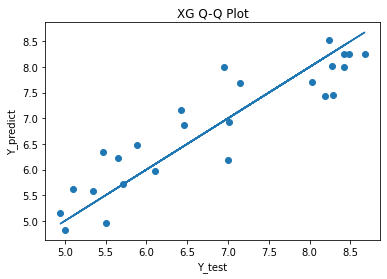

In [49]:
plt.scatter(Y_test,Y_predict)
plt.plot(Y_test,Y_test)
plt.xlabel('Y_test')
plt.ylabel('Y_predict')
plt.title('XG Q-Q Plot')

Text(0.5, 1.0, 'XG Boosting R2 Scores Compared')

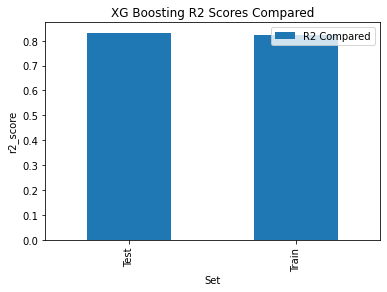

In [50]:
Scores = pd.DataFrame({'Set' : ['Test','Train'],
                        'R2 Compared' : [r2_xg_test,r2_xg_train]})
Scores.set_index('Set', inplace = True)
Scores.plot.bar()
plt.ylabel('r2_score')
plt.title('XG Boosting R2 Scores Compared')

In [51]:
estimator_gb = GradientBoostingRegressor()
param_grid = { 
            "loss"      : ['ls','lad'],
            "n_estimators"      : [30,50,100],
            "learning_rate": [0.05,0.1,0.15,0.2],
            }

grid_gb = GridSearchCV(estimator_gb, param_grid, n_jobs=-1, cv=6)

grid_gb.fit(X_train, Y_train)
print('Best Parameters:\n',grid_gb.best_params_)

Best Parameters:
 {'learning_rate': 0.1, 'loss': 'ls', 'n_estimators': 50}


In [52]:
grid_gb.get_params()

{'cv': 6,
 'error_score': nan,
 'estimator__alpha': 0.9,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'ls',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_iter_no_change': None,
 'estimator__random_state': None,
 'estimator__subsample': 1.0,
 'estimator__tol': 0.0001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': GradientBoostingRegressor(),
 'n_jobs': -1,
 'param_grid': {'loss': ['ls', 'lad'],
  'n_estimators': [30, 50, 100],
  'learning_rate': [0.05, 0.1, 0.15, 0.2]},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_t

In [53]:
Y_predict = grid_gb.predict(X_test)
r2_gb_test = r2_score(Y_test,Y_predict)
print('Gradient Boost Test set R2 Score is',r2_score(Y_test,Y_predict))
list_r2.append(r2_score(Y_test,Y_predict))
list_mse.append(mean_squared_error(Y_test,Y_predict))

Gradient Boost Test set R2 Score is 0.7468995096986655


In [54]:
Y_predict_train = grid_gb.predict(X_train)
r2_gb_train = r2_score(Y_train,Y_predict_train)
print('Gradient Boost Train set R2 Score is',r2_score(Y_train,Y_predict_train))

Gradient Boost Train set R2 Score is 0.7557096757272399


Text(0.5, 1.0, 'GB Q-Q Plot')

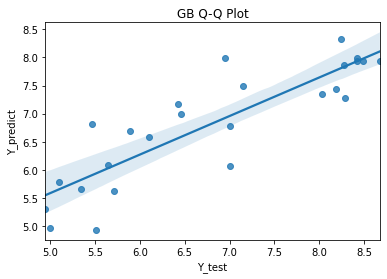

In [55]:
sns.regplot(Y_test,Y_predict)
plt.xlabel('Y_test')
plt.ylabel('Y_predict')
plt.title('GB Q-Q Plot')

Text(0.5, 1.0, 'GB')

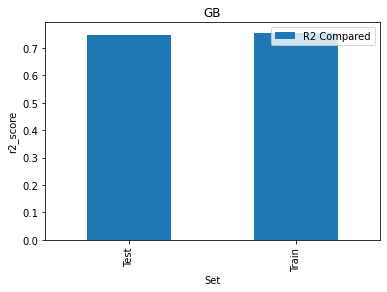

In [56]:
Scores = pd.DataFrame({'Set' : ['Test','Train'],
                        'R2 Compared' : [r2_gb_test,r2_gb_train]})
Scores.set_index('Set', inplace = True)
Scores.plot.bar()
plt.ylabel('r2_score')
plt.title('GB')

In [57]:
mean_sq_error = []
for i in range(2,7):
    estimator_knn = KNeighborsRegressor(n_neighbors = i)
    estimator_knn.fit(X_train, Y_train)
    Y_predict = estimator_knn.predict(X_train)
    mean_sq_error.append(mean_squared_error(Y_train,Y_predict))
print(mean_sq_error)  

[0.31238016997717627, 0.5062133473026672, 0.5837886912648071, 0.6420346076218011, 0.6679768032862802]


<AxesSubplot:xlabel='K_neigbours', ylabel='Mean_Squared_error'>

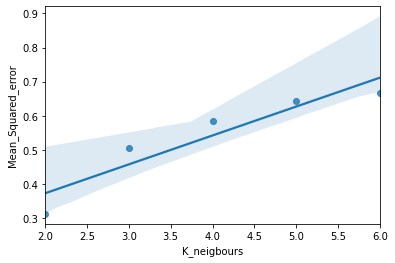

In [58]:
KNN_Df = pd.DataFrame({'K_neigbours' : [2,3,4,5,6],
                      'Mean_Squared_error' : mean_sq_error})
sns.regplot(KNN_Df['K_neigbours'],KNN_Df['Mean_Squared_error'])

In [59]:
KNN_Df

,K_neigbours,Mean_Squared_error
0,2,0.312380
1,3,0.506213
2,4,0.583789
3,5,0.642035
4,6,0.667977


In [60]:
estimator_knn = KNeighborsRegressor(n_neighbors = 2)
estimator_knn.fit(X_train, Y_train)
Y_predict = estimator_knn.predict(X_train)
r2_score(Y_train,Y_predict)

0.772081517591844

In [61]:
Y_test_predict = estimator_knn.predict(X_test)
r2_score(Y_test,Y_test_predict)

0.756725046890121

Text(0.5, 1.0, 'KNN Q-Q Plot')

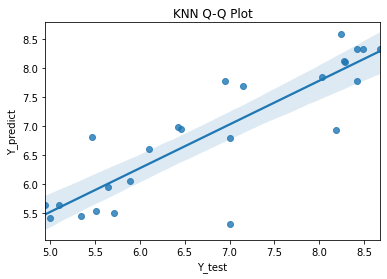

In [62]:
sns.regplot(Y_test,Y_test_predict)
plt.xlabel('Y_test')
plt.ylabel('Y_predict')
plt.title('KNN Q-Q Plot')

In [63]:
list_r2.append(r2_score(Y_test,Y_test_predict))
list_mse.append(mean_squared_error(Y_test,Y_test_predict))

Text(0.5, 1.0, 'GB')

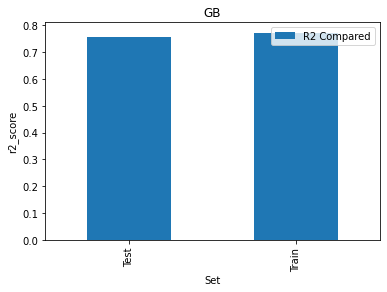

In [64]:
Scores = pd.DataFrame({'Set' : ['Test','Train'],
                        'R2 Compared' : [r2_score(Y_test,Y_test_predict),r2_score(Y_train,Y_predict)]})
Scores.set_index('Set', inplace = True)
Scores.plot.bar()
plt.ylabel('r2_score')
plt.title('GB')

In [65]:
list_mse

[0.38642333932836864,
 0.2746767429934567,
 0.41423804463332464,
 0.39815703543095304]

In [66]:
list_r2

[0.7638943648103034, 0.8321718170827213, 0.7468995096986655, 0.756725046890121]

Text(0.5, 1.0, 'Comparison of R2 Scores between the Algorithms')

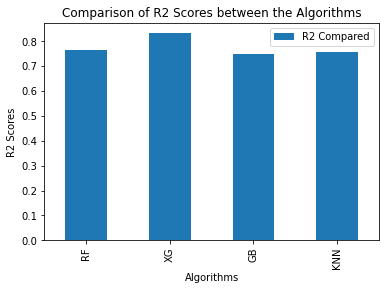

In [67]:
Scores = pd.DataFrame({'Algorithms' : ['RF','XG','GB','KNN'],
                        'R2 Compared' : list_r2})
Scores.set_index('Algorithms', inplace = True)
Scores.plot.bar()
plt.ylabel('R2 Scores')
plt.title('Comparison of R2 Scores between the Algorithms')

Text(0.5, 1.0, 'MSE Compared')

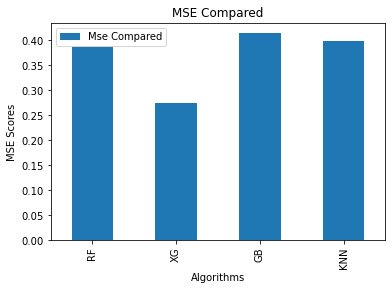

In [68]:
Scores = pd.DataFrame({'Algorithms' : ['RF','XG','GB','KNN'],
                        'Mse Compared' : list_mse})
Scores.set_index('Algorithms', inplace = True)
Scores.plot.bar()
plt.ylabel('MSE Scores')
plt.title('MSE Compared')

In [69]:
lis_mis = list_mse[0:2]
lis_mis

[0.38642333932836864, 0.2746767429934567]

In [70]:
list_mae

[0.5619892062671625, 0.44781978718324245]

In [71]:
list_final = lis_mis+list_mae
list_final

[0.38642333932836864,
 0.2746767429934567,
 0.5619892062671625,
 0.44781978718324245]

Text(0.5, 1.0, 'Comparision of Errors')

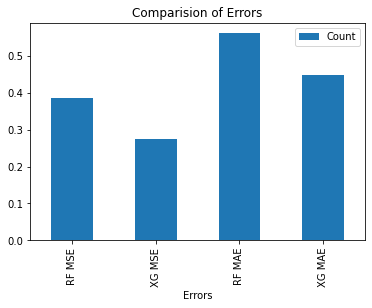

In [72]:
dict_final = pd.DataFrame({'Errors': ['RF MSE','XG MSE','RF MAE','XG MAE'],'Count':list_final})
dict_final.set_index('Errors', inplace = True)
dict_final.plot.bar()
plt.title('Comparision of Errors')

Text(0.5, 1.0, 'RF Actual vs Predicted')

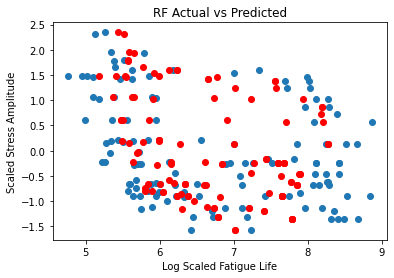

In [73]:
plt.scatter(Total_Data['Log Scale'],Total_Data['Stress Amplitude (Mpa)'])
plt.scatter(grid_rf.predict(Total_Data[['Energy','Stress Amplitude (Mpa)']]),Total_Data['Stress Amplitude (Mpa)'],color = 'red')
plt.xlabel('Log Scaled Fatigue Life')
plt.ylabel('Scaled Stress Amplitude')
plt.title('RF Actual vs Predicted')

Text(0.5, 1.0, 'XG Actual vs Predicted')

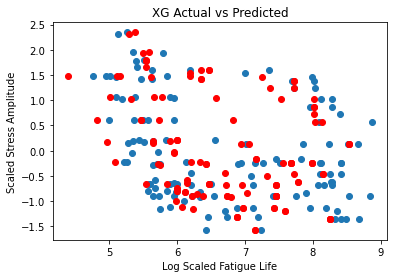

In [74]:
plt.scatter(Total_Data['Log Scale'],Total_Data['Stress Amplitude (Mpa)'])
plt.scatter(grid_xg.predict(Total_Data[['Energy','Stress Amplitude (Mpa)']]),Total_Data['Stress Amplitude (Mpa)'],color = 'red')
plt.xlabel('Log Scaled Fatigue Life')
plt.ylabel('Scaled Stress Amplitude')
plt.title('XG Actual vs Predicted')

Text(0.5, 1.0, 'GB Actual vs Predicted')

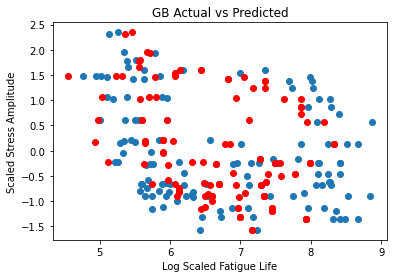

In [75]:
plt.scatter(Total_Data['Log Scale'],Total_Data['Stress Amplitude (Mpa)'])
plt.scatter(grid_gb.predict(Total_Data[['Energy','Stress Amplitude (Mpa)']]),Total_Data['Stress Amplitude (Mpa)'],color = 'red')
plt.xlabel('Log Scaled Fatigue Life')
plt.ylabel('Scaled Stress Amplitude')
plt.title('GB Actual vs Predicted')

Text(0.5, 1.0, 'KNN Actual vs Predicted')

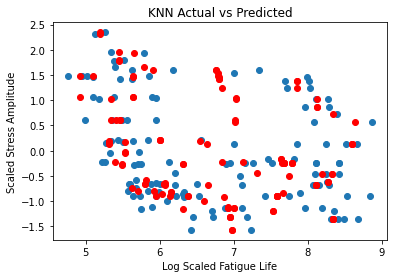

In [76]:
plt.scatter(Total_Data['Log Scale'],Total_Data['Stress Amplitude (Mpa)'])
plt.scatter(estimator_knn.predict(Total_Data[['Energy','Stress Amplitude (Mpa)']]),Total_Data['Stress Amplitude (Mpa)'],color = 'red')
plt.xlabel('Log Scaled Fatigue Life')
plt.ylabel('Scaled Stress Amplitude')
plt.title('KNN Actual vs Predicted')